# Import Library

In [1]:
import numpy as np
import pandas as pd
import json
from utils.utils import *

import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import category_encoders as ce

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *
import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
def format_pytorch_version(version):
    return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load Data

In [3]:
df_test = pd.read_csv('data/test/test.csv')
gridhist = pd.read_csv('data/test/last_hope_test.csv')
df_test = df_test.join(gridhist.set_index('MOFname'), on='MOFname')
print(df_test.dtypes)

MOFname                                           object
volume [A^3]                                     float64
weight [u]                                       float64
surface_area [m^2/g]                             float64
void_fraction                                    float64
void_volume [cm^3/g]                             float64
functional_groups                                 object
metal_linker                                       int64
organic_linker1                                    int64
organic_linker2                                    int64
topology                                          object
CO2/N2_selectivity                               float64
heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]    float64
0                                                float64
1                                                float64
2                                                float64
3                                                float64
4                              

In [5]:
df_test.isna().sum()

MOFname                                          0
volume [A^3]                                     0
weight [u]                                       0
surface_area [m^2/g]                             0
void_fraction                                    0
void_volume [cm^3/g]                             0
functional_groups                                0
metal_linker                                     0
organic_linker1                                  0
organic_linker2                                  0
topology                                         0
CO2/N2_selectivity                               0
heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]    0
0                                                0
1                                                0
2                                                0
3                                                0
4                                                0
5                                                0
6                              

# Load dependent data

In [6]:
features = json.load(open('model/general/features.json', 'r'))
features_idx = json.load(open('model/general/features_idx.json', 'r'))

topo_encoder = json.load(open('model/general/encoder/topology_encoder.json', 'r'))
func_encoder = json.load(open('model/general/encoder/functional_groups_encoder.json', 'r'))
hash_encoder = pickle.load(open('model/hash_encode_topology.pkl', 'rb'))

# Preprocessing Data

## Insert Density

In [7]:
df_test.insert(loc=3, column="density [g/cm^3]", value=(df_test["weight [u]"] / df_test["volume [A^3]"]) * 1.66054)

## Generate catalog

In [8]:
generate_selectivity_catalog(df_test)

,MOFname,volume [A^3],weight [u],density [g/cm^3],surface_area [m^2/g],void_fraction,void_volume [cm^3/g],functional_groups,metal_linker,organic_linker1,...,2,3,4,5,6,7,8,9,10,11
0,mof_unit_68614,1208.301332,797.70936,1.096273,586.54,0.11392,0.1039,OEt,2,5,...,0.029754,0.085012,0.074386,0.052070,0.040381,0.045694,0.039318,0.042506,0.032942,0.014877
1,mof_unit_68615,4126.414623,3733.65779,1.502488,852.49,0.21367,0.1422,H-I,4,6,...,0.003929,0.003820,0.007750,0.035692,0.143203,0.117225,0.046061,0.034600,0.025213,0.022266
2,mof_unit_68616,1602.148373,747.21048,0.774443,3155.73,0.33883,0.4375,CN-OH,3,11,...,0.087671,0.119843,0.098931,0.100808,0.095982,0.053353,0.039143,0.029224,0.030832,0.023593
3,mof_unit_68617,2436.629312,995.80232,0.678630,3521.09,0.40464,0.5963,OMe,2,1,...,0.011544,0.036536,0.087829,0.112345,0.125912,0.153404,0.072834,0.023921,0.018923,0.014757
4,mof_unit_68618,3123.418006,1337.53800,0.711091,2678.46,0.38959,0.5479,NO2-Pr,3,8,...,0.006221,0.020045,0.031005,0.052432,0.072773,0.110592,0.157890,0.158877,0.048483,0.016885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,mof_unit_85609,32660.944605,4723.68288,0.240160,5720.14,0.77614,3.2318,OH-NO2,3,3,...,0.002510,0.005413,0.009350,0.017346,0.029882,0.047154,0.073527,0.106513,0.183388,0.411512
16996,mof_unit_85610,5070.998617,1499.13262,0.490903,4017.28,0.59192,1.2058,Me-OMe,3,1,...,0.002413,0.009846,0.022692,0.039352,0.083952,0.128651,0.146093,0.158157,0.167253,0.050893
16997,mof_unit_85611,4669.804446,1322.04892,0.470109,4288.76,0.54950,1.1689,Me-CN,2,7,...,0.004011,0.007408,0.014109,0.025434,0.049689,0.083994,0.137930,0.183136,0.210882,0.055634
16998,mof_unit_85612,4682.120862,1213.51148,0.430379,4331.86,0.60643,1.4091,OH-HCO,3,7,...,0.004918,0.006722,0.010738,0.026477,0.042297,0.064593,0.116071,0.173451,0.227716,0.090660


## Encode Data

In [9]:
encoder = {'functional_groups': func_encoder}
df_test = df_test.replace(encoder)

topo_encode = hash_encoder.transform(df_test['topology'])

topo_name = list(topo_encode.columns)
topo_rename = {}

for i in range(len(topo_name)):
    topo_rename[topo_name[i]] = "topo_{}".format(i)

topo_encode = topo_encode.rename(columns = topo_rename)

df_test = df_test.drop('topology', axis=1)
df_test = pd.concat([topo_encode, df_test], axis=1)
print(df_test.dtypes)

topo_0                                             int64
topo_1                                             int64
topo_2                                             int64
topo_3                                             int64
topo_4                                             int64
topo_5                                             int64
topo_6                                             int64
topo_7                                             int64
topo_8                                             int64
topo_9                                             int64
MOFname                                           object
volume [A^3]                                     float64
weight [u]                                       float64
density [g/cm^3]                                 float64
surface_area [m^2/g]                             float64
void_fraction                                    float64
void_volume [cm^3/g]                             float64
functional_groups              

## Select features

### Normal

In [10]:
X = df_test[features].values

# mol2vec_feat = pickle.load(open("data/test/mol2vec.pkl", "rb"))
# latent_space = pickle.load(open("data/test/latent_space_GINE.pkl", "rb"))
# nan_idx = []
# for idx, i in enumerate(mol2vec_feat):
#     if type(i) == float:
#         nan_idx.append(idx)

# mask = np.ones((17000,), dtype=bool)
# mask[nan_idx] = False

# X = X[mask]
# mol2vec_feat = mol2vec_feat[mask]

# expand_dim = lambda x:np.expand_dims(x, axis=0)
# mol2vec_feat = np.concatenate(list(map(expand_dim, mol2vec_feat)), axis=0)

# X = np.concatenate((X, latent_space, mol2vec_feat), axis=1)

### GNN concat

In [5]:
df_test = pd.read_csv('data/test/auto_SAGE_feat_test.csv')
X = df_test[features].values

## Convert CO2/N2 selectivity by square root selectivity and multiply by heat adsorption

In [145]:
# X[:, features_idx['CO2/N2_selectivity']] = np.sqrt(X[:, features_idx['CO2/N2_selectivity']]) * X[:, features_idx['heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]']]

## Scale Data

In [11]:
sc = pickle.load(open('model/general/standardscaler.pkl', 'rb'))
X = sc.transform(X)

# Model

## MLP

In [6]:
class MLP(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU() 
        
        self.fc2 = nn.Linear(64, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(128, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        
        self.fc4 = nn.Linear(256, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.01)
        
        self.output = nn.Linear(512, 1)
        
    def forward(self, x, batch_norm=False):
        x = self.fc1(x)
        if batch_norm:
            x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.fc2(x)
        if batch_norm:
            x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.fc3(x)
        if batch_norm:
            x = self.bn3(x)
        x = self.relu3(x)
        
        x = self.fc4(x)
        if batch_norm:
            x = self.bn4(x)
        x = self.relu4(x)
        x = self.dropout(x)
        
        output = self.output(x)
        return output

In [7]:
model = MLP(X.shape[1], 1).to(device)
model.load_state_dict(torch.load("model/mlp.pt"))
model.eval()

MLP(
  (fc1): Linear(in_features=277, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=256, out_features=512, bias=True)
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.01, inplace=False)
  (output): Linear(in_features=512, out_features=1, bias=True)
)

In [8]:
torch.tensor(X).shape

torch.Size([16237, 277])

In [9]:
y_mlp = model(torch.tensor(X).to(device).float())

In [10]:
y_mlp = y_mlp.detach().cpu().numpy()

In [11]:
y_mlp.shape

(16237, 1)

In [12]:
y_mlp

array([[189.37973  ],
       [ 68.59271  ],
       [ 67.384155 ],
       ...,
       [  0.4457953],
       [ -1.3817979],
       [ -4.8175716]], dtype=float32)

## XGBoost

In [12]:
model = xgb.XGBRegressor()
model.load_model('model/model.json')

y = model.predict(X)

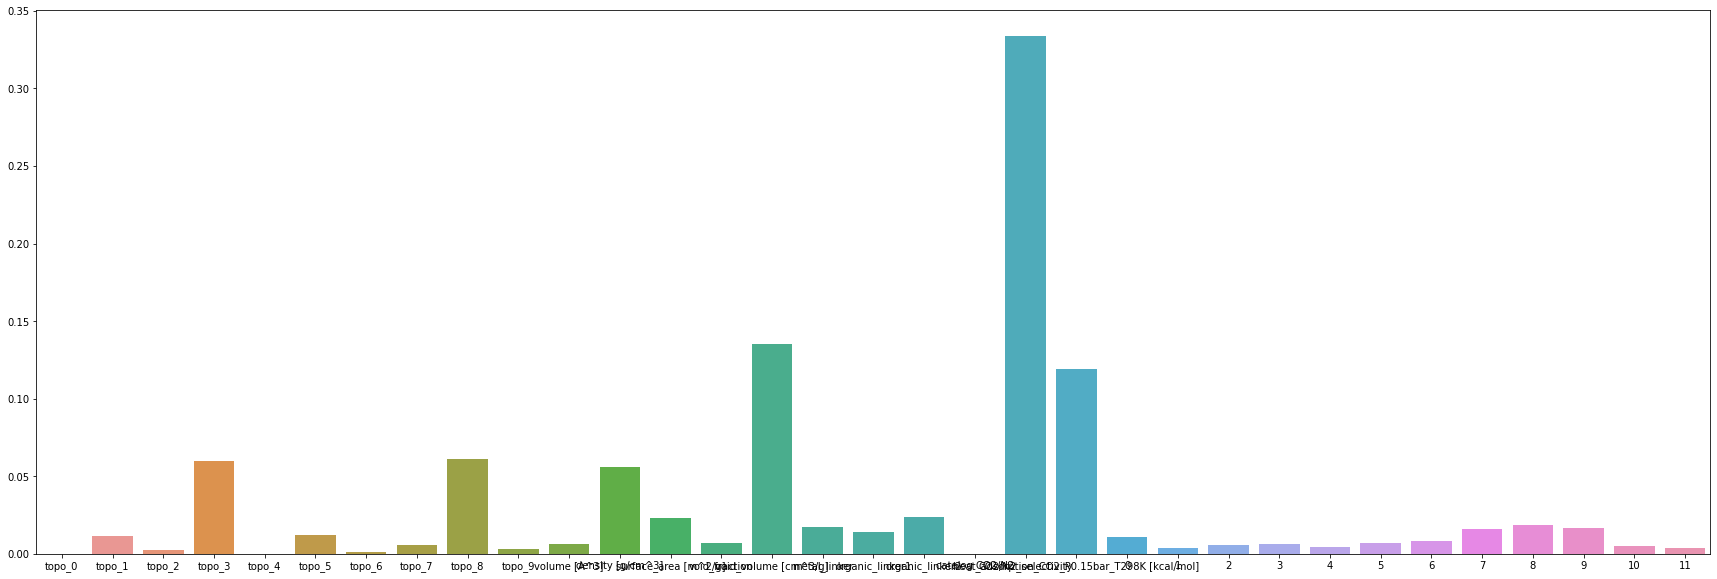

In [13]:
plt.figure(figsize=(30, 10))
sns.barplot(x=features, y=model.feature_importances_)
plt.show()

In [13]:
y[mask] = y_mlp.flatten()

NameError: name 'y_mlp' is not defined

In [14]:
id_ = np.array(df_test['MOFname'])

cut_mof_unit = lambda x: x.split('_')[-1]
id_ = np.array(list(map(cut_mof_unit, id_)))
d = {'id': id_, 'CO2_working_capacity [mL/g]': y}

df_inference = pd.DataFrame(d)

In [15]:
df_inference.to_csv('xgboost_submission_hist.csv', index=False)

# Fill XGBoost prediction with MLP Prediction

In [13]:
df_inference = pd.read_csv('xgboost_submission.csv')

In [15]:
y = df_inference['CO2_working_capacity [mL/g]'].values
y[mask] = y_mlp.flatten()

In [16]:
df_inference.to_csv('submission.csv', index=False)